<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/colaborative%20filter/00_FC_Recommender_System_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/colaborative filter'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en un entorno local.


In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from sklearn.neighbors import NearestNeighbors
from surprise.model_selection import cross_validate, train_test_split, KFold ,GridSearchCV , RandomizedSearchCV

In [3]:
#Carga de datos y preprocesado

dataFrame = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')

print(dataFrame.shape)

data = dataFrame.copy()
# data = data.sample(n=100000, random_state=42)

# Inserta la columna 'rating' en la última posición del DataFrame
data.insert(len(data.columns)-1, 'rating', data.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
data.insert(len(data.columns)-2, 'relevance', data.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
data.insert(5, 'tag_etiquetas_genómicas', data.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
data.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
data = data.drop(columnas_a_eliminar, axis=1)
print(data.shape)
data.head()

df = data.copy()

(8949372, 13)
(8949372, 11)


In [4]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

6550      217078
160540    128670
155146    126249
131347    102899
14116      92277
           ...  
152361         3
107106         3
46748          3
81807          3
113230         3
Name: userId, Length: 12918, dtype: int64

In [5]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()


4.0    2067570
5.0    1901803
4.5    1518686
3.5    1349780
3.0     895858
2.5     437718
2.0     335858
1.5     167000
1.0     148428
0.5     126671
Name: rating, dtype: int64

In [6]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [7]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

296       84546
260       66668
2571      56432
79132     46900
4973      38592
          ...  
4879          4
2873          3
5289          3
4113          3
147300        3
Name: movieId, Length: 12105, dtype: int64

In [8]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Take Care of My Cat (Goyangileul butaghae) (2001)                      5.0
Celine and Julie Go Boating (Celine et Julie vont en bateau) (1974)    5.0
Nil By Mouth (1997)                                                    5.0
Our Lady of the Assassins (Virgen de los sicarios, La) (2000)          5.0
Haiku Tunnel (2001)                                                    5.0
Winnie the Pooh and the Day of Concern (1972)                          5.0
Benny Goodman Story, The (1955)                                        5.0
Duets (2000)                                                           5.0
Dance of Reality, The (Danza de la realidad, La) (2013)                5.0
Louis C.K.: One Night Stand (2005)                                     5.0
Name: rating, dtype: float64

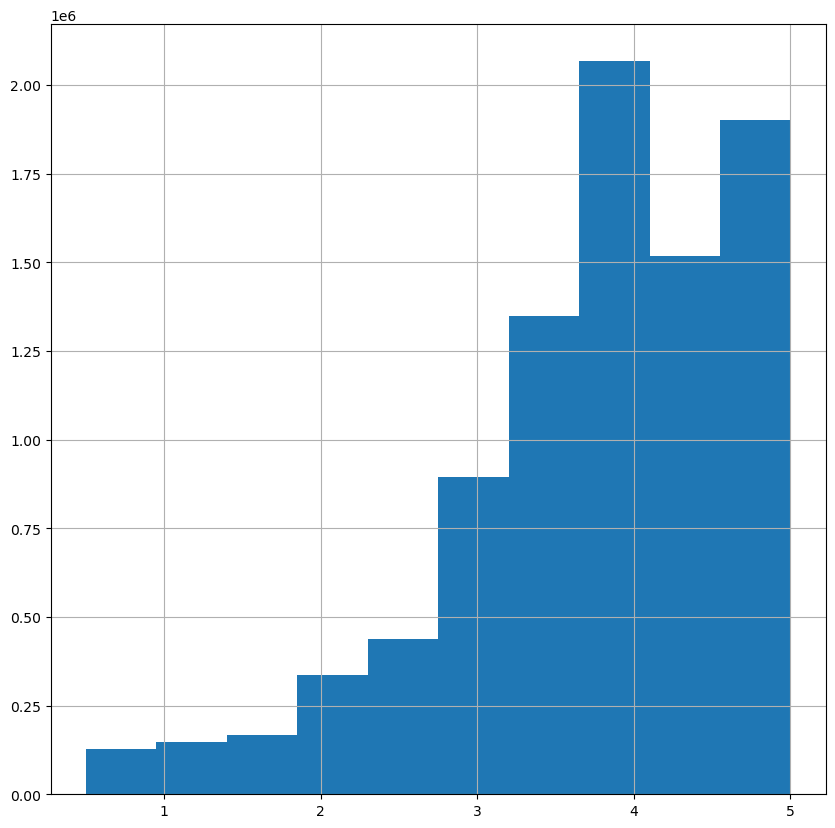

In [9]:
#hisotgrama de la distribución de las disitntas calificaciones
df['rating'].hist(figsize= (10,10))
plt.show()

### Analizar la distribución del número de votos (o calificaciones) dados por los usuarios a las películas y el número de películas calificadas por cada usuario en un conjunto de datos de películas.

In [10]:
dataFrame = data.copy()

In [11]:
# Contar el número de votos (calificaciones) por cada película
numberOf_user_voted_for_movie = pd.DataFrame(dataFrame.groupby('movieId')['rating'].agg('count'))
numberOf_user_voted_for_movie.reset_index(level = 0,inplace = True)
numberOf_user_voted_for_movie.head()

,movieId,rating
0,1,8064
1,2,2262
2,3,231
3,4,65
4,5,210


In [12]:
# Descripción estadística del número de votos por película
numberOf_user_voted_for_movie.describe()

,movieId,rating
count,12105.000000,12105.000000
mean,48374.156795,739.312020
std,56019.078329,2308.418884
min,1.000000,3.000000
25%,4102.000000,56.000000
50%,25855.000000,160.000000
75%,84601.000000,490.000000
max,206499.000000,84546.000000


La tabla proporciona estadísticas descriptivas sobre el número de votos por película (rating) en el conjunto de datos. Aquí está la interpretación de las estadísticas:

1. count (Recuento):
    Hay 12,105 películas en el conjunto de datos.
    
2. mean (Media):
    La media del número de votos por película es aproximadamente 739.31.

3. std (Desviación estándar):
    La desviación estándar es alta, aproximadamente 2308.42. Esto indica que la variabilidad en el número de votos por película es significativa y que hay películas con un rango amplio de votos.

4. min (Mínimo):
    La película con el menor número de votos tiene 3 votos.

5. 25% (Cuartil 1 - Q1):
    El 25% de las películas tienen 56 votos o menos.

6. 50% (Cuartil 2 - Mediana):
    La mediana (o el percentil 50) es 160, lo que significa que el 50% de las películas tienen 160 votos o menos.

7. 75% (Cuartil 3 - Q3):
    El 75% de las películas tienen 490 votos o menos.

8. max (Máximo):
    La película con el mayor número de votos tiene 84,546 votos.
    
En resumen, la distribución del número de votos por película varía significativamente, con algunas películas que tienen un gran número de votos, mientras que otras tienen menos votos. La mediana proporciona una indicación de la tendencia central, y la alta desviación estándar sugiere que la dispersión es amplia, lo que significa que algunas películas tienen una cantidad significativamente mayor de votos que otras.

In [13]:
# Se cuenta el número de películas calificadas por cada usuario.
numberOf_movies_voted_by_user = pd.DataFrame(dataFrame.groupby('userId')['rating'].agg('count'))
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)
numberOf_movies_voted_by_user.head()

,userId,rating
0,3,28
1,4,97
2,19,84
3,20,10
4,43,8


In [14]:
# Descripción estadística del número de películas calificadas por usuario
numberOf_movies_voted_by_user.describe()

,userId,rating
count,12918.000000,12918.000000
mean,81086.895340,692.783093
std,46818.876612,4142.736011
min,3.000000,3.000000
25%,40541.750000,26.000000
50%,81206.500000,56.000000
75%,121879.000000,235.000000
max,162521.000000,217078.000000


La tabla proporciona estadísticas descriptivas sobre el número de películas calificadas (rating) por usuario en el conjunto de datos. Aquí está la interpretación de las estadísticas:

1. count (Recuento):
    Hay 12,918 usuarios en el conjunto de datos.

2. mean (Media):
    La media del número de películas calificadas por usuario es aproximadamente 692.78.

3. std (Desviación estándar):
    La desviación estándar es alta, aproximadamente 4142.74. Esto indica que la variabilidad en el número de películas calificadas por usuario es significativa y que hay usuarios que han calificado un rango amplio de películas.

4. min (Mínimo):
    El usuario con el menor número de películas calificadas ha calificado al menos 3 películas.

5. 25% (Cuartil 1 - Q1):
    El 25% de los usuarios han calificado 26 películas o menos.

6. 50% (Cuartil 2 - Mediana):
    La mediana (o el percentil 50) es 56, lo que significa que el 50% de los usuarios han calificado 56 películas o menos.

7. 75% (Cuartil 3 - Q3):
    El 75% de los usuarios han calificado 235 películas o menos.

8. max (Máximo):
    El usuario con el mayor número de películas calificadas ha calificado hasta 217,078 películas.

En resumen, la distribución del número de películas calificadas por usuario varía significativamente, con algunos usuarios que han calificado un gran número de películas y otros que han calificado menos. La mediana proporciona una indicación de la tendencia central, y la alta desviación estándar sugiere que la dispersión es amplia, lo que significa que algunos usuarios han calificado muchas más películas que otros.

Text(0, 0.5, 'Número de votos de usuariuos por pelicula')

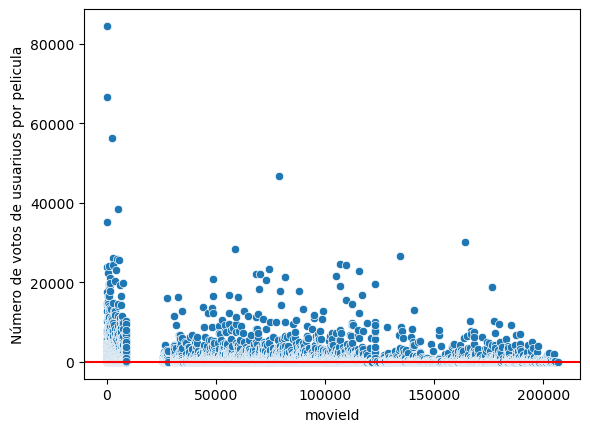

In [15]:
# Visualización del número de votos por película
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'movieId', data = numberOf_user_voted_for_movie)
plt.axhline(y=50,color='r')
plt.ylabel('Número de votos de usuariuos por pelicula')

Text(0, 0.5, 'Número de peliculas calificadas por usuario')

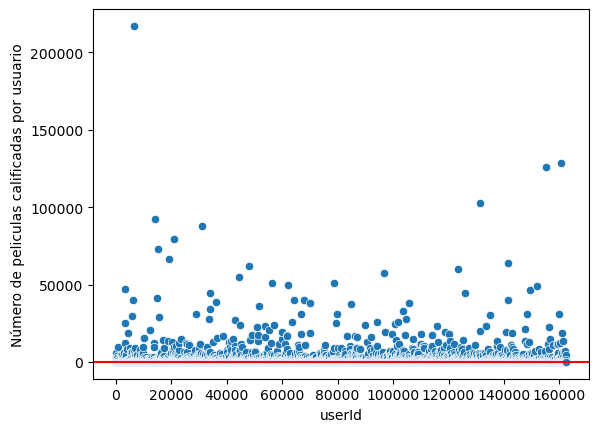

In [16]:
# Número de películas calificadas por cada usuario
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Número de peliculas calificadas por usuario')

In [17]:
#Data frame con la media de calificaciones por pelicula y nímero de calificaciones
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['rating_numbers'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,rating_numbers
title,,
'71 (2014),3.800000,220
'Round Midnight (1986),4.500000,12
'Salem's Lot (2004),5.000000,18
"'burbs, The (1989)",3.336735,392
'night Mother (1986),4.000000,48


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


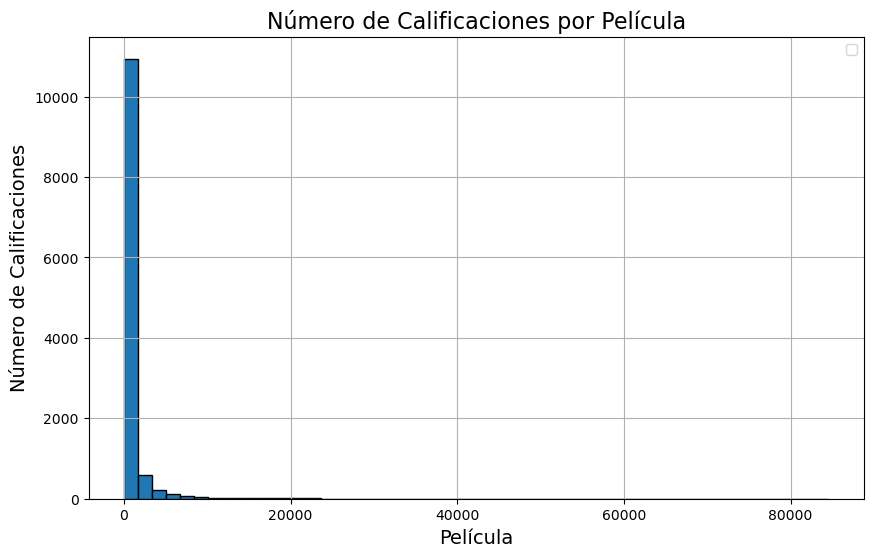

In [18]:
# Gráfica de dispersión para el número de usuarios que votaron por película
plt.figure(figsize=(10, 6))

plt.rcParams['patch.force_edgecolor'] = True

# Scatter plot
ratings['rating_numbers'].hist(bins=50)


# Títulos y etiquetas de los ejes
plt.title('Número de Calificaciones por Película', fontsize=16)
plt.xlabel('Película', fontsize=14)
plt.ylabel('Número de Calificaciones', fontsize=14)

# Leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


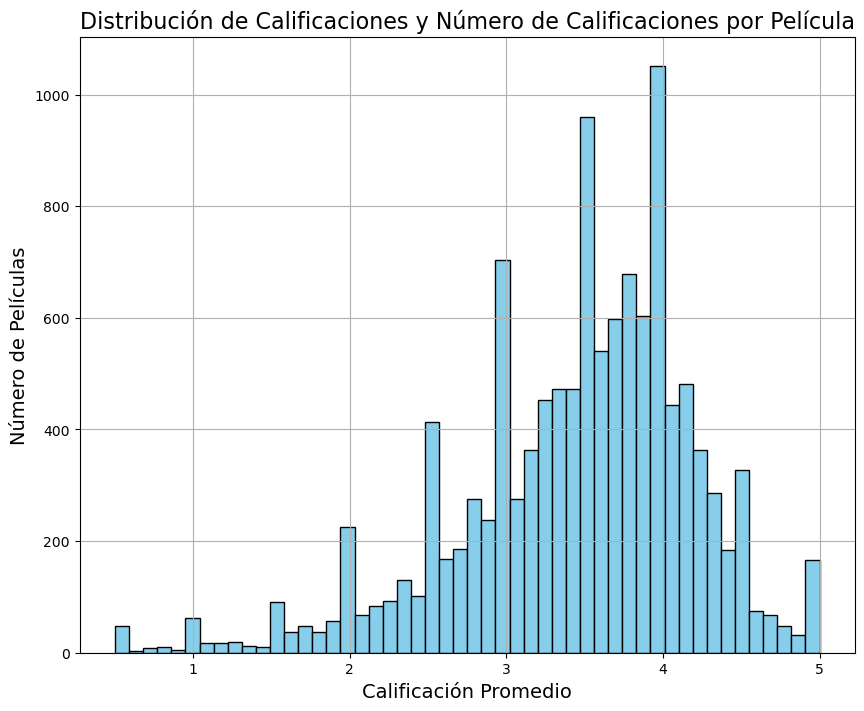

In [19]:
# Crear el histograma
plt.figure(figsize=(10, 8))
plt.rcParams['patch.force_edgecolor'] = True
ratings['rating'].hist(bins=50, color='skyblue', edgecolor='black')

# Títulos y etiquetas de los ejes
plt.title('Distribución de Calificaciones y Número de Calificaciones por Película', fontsize=16)
plt.xlabel('Calificación Promedio', fontsize=14)
plt.ylabel('Número de Películas', fontsize=14)

# Mostrar la gráfica
plt.show()


<Figure size 1000x800 with 0 Axes>

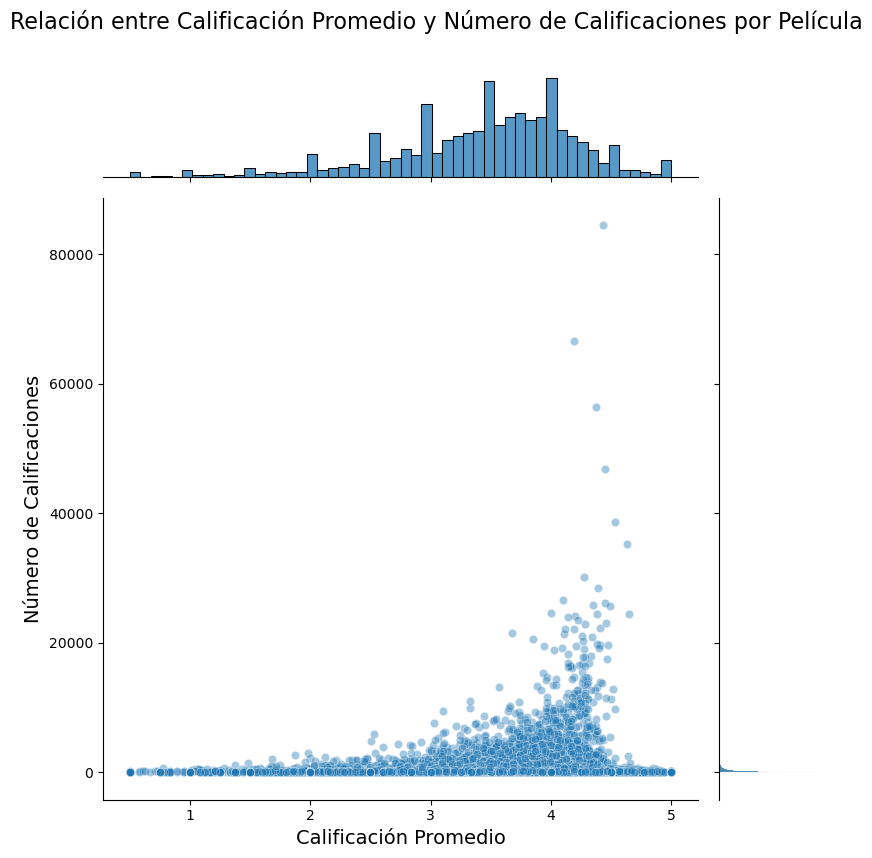

In [20]:
# Crear el gráfico conjunto
plt.figure(figsize=(10, 8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_numbers', data=ratings, alpha=0.4, height=8)

# Títulos y etiquetas de los ejes
plt.suptitle('Relación entre Calificación Promedio y Número de Calificaciones por Película', fontsize=16, y=1.06)
plt.xlabel('Calificación Promedio', fontsize=14)
plt.ylabel('Número de Calificaciones', fontsize=14)

# Mostrar la gráfica
plt.show()


C:\Users\jaime\AppData\Local\Temp\ipykernel_15168\1661798920.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tc = df.corr()


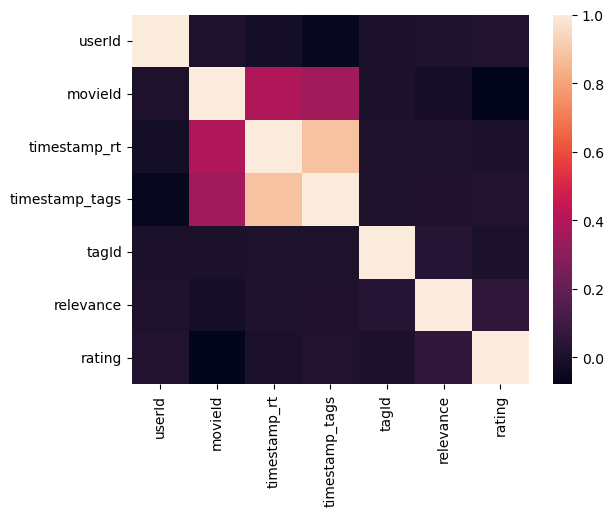

In [21]:
# Correlación de las diferentes variables usando un mapa de calor.
# Util para identificar patrones y ralciones entre variables.
# 1 (color claro): Correlación perfecta positiva. Aumentos en una variable se asocian
#     con aumentos proporcionales en la otra en una relación lineal perfecta.

# 0 (color intermedio): Falta de correlación. No hay una relación lineal entre las dos variables;
#     cambios en una variable no predicen cambios en la otra.
tc = df.corr()
sns.heatmap(tc)
plt.show()

In [22]:
#Creación de una matriz Pivot table
#Matriz que representa las calificaciones dadas por los usuarios a las películas.
# Las filas representan usuarios, las columnas representan títulos de películas y los valores son las calificaciones.
# Las celdas que no tienen calificación se llenan con ceros.
pivot_table_result_based_user = df.pivot_table(index='userId', columns='title', values='rating')
pivot_table_result_based_user.fillna(0, inplace=True)
pivot_table_result_based_user.shape
pivot_table_result_based_user.head()

title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),...,[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Creación de una matriz Pivot table con un umbral de al menos 10 peliuculas calificadas
print("Before: ",pivot_table_result_based_user.shape)
pivot_table_umbral_rating = pivot_table_result_based_user.copy()
pivot_table_umbral_rating = pivot_table_umbral_rating.dropna(thresh=10, axis=1).fillna(0,axis=1)
print("After: ",pivot_table_umbral_rating.shape)

Before:  (12918, 12104)
After:  (12918, 12104)


In [24]:
# Pivot table sin rellenar 0
pivot_table_nan = df.pivot_table(index='userId', columns='title', values='rating')
pivot_table_nan.shape
pivot_table_nan.head()

title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),...,[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sí, tiene sentido eliminar filas duplicadas antes de crear la tabla pivote, especialmente si estás trabajando con datos de calificaciones de usuarios donde cada fila representa la calificación de un usuario para una película específica. Algunas razones para hacer esto son:

1. **Evitar Duplicados en la Tabla Pivote:**
   - Eliminar duplicados garantiza que no haya varias entradas para la misma combinación de usuario y película al crear la tabla pivote. Esto es crucial para obtener resultados coherentes y evitar distorsiones en las correlaciones.

2. **Precisión y Consistencia:**
   - La eliminación de duplicados mejora la precisión de las correlaciones, ya que cada entrada en la tabla pivote representa de manera única una calificación de un usuario para una película específica. Esto ayuda a evitar que las correlaciones estén influenciadas por datos duplicados.

3. **Eficiencia Computacional:**
   - Al reducir el tamaño del conjunto de datos antes de crear la tabla pivote, puedes mejorar la eficiencia computacional, especialmente si tienes un gran conjunto de datos. Menos duplicados significa menos cálculos y un mejor rendimiento.

La línea de código que proporcionaste, `ratings = ratings.drop_duplicates(subset=['userId', 'movieId'])`, eliminará las filas duplicadas basadas en las columnas 'userId' y 'movieId'. Asegúrate de revisar los resultados después de esta operación para confirmar que los duplicados se han eliminado según tus expectativas.

In [25]:
# Se implementa el recomendador según una pelicula. Se usa la función de correlación.

def recomendar_peliculas(nombre_pelicula, tabla_pivote, ratings,
                         min_cantidad_calificaciones=50, tipo_correlacion='pearson'):
    """
    Recomienda películas basadas en la correlación de calificaciones de usuarios.

    Parámetros:
    - nombre_pelicula: Nombre de la película para la cual se desean recomendaciones.
    - tabla_pivote: DataFrame que contiene las calificaciones de los usuarios (formato de tabla pivote).
    - ratings: DataFrame que contiene información adicional, incluyendo 'cantidad_calificaciones'.
    - min_cantidad_calificaciones: Cantidad mínima de calificaciones para considerar una película.
    - tipo_correlacion: Tipo de correlación a utilizar (pearson, kendall, spearman).

    Retorna:
    - DataFrame de películas recomendadas con puntajes de correlación.
    """

    # Extraer las calificaciones de usuarios para la película especificada
    calificaciones_usuario = tabla_pivote[nombre_pelicula]

    # Calcular correlaciones con otras películas.
    # Usando correlación de Pearson default
    # Compara las calificaciones de la película de entrada con las
    # calificaciones de cada otra película en términos de su similitud
    peliculas_similares = tabla_pivote.corrwith(calificaciones_usuario, method=tipo_correlacion)

    # Crear un DataFrame con los puntajes de correlación
    peliculas_corr = pd.DataFrame(peliculas_similares, columns=['Correlacion'])

    # Eliminar películas sin datos de correlación
    peliculas_corr.dropna(inplace=True)

    # Unir con el DataFrame de calificaciones para considerar la cantidad mínima de calificaciones
    peliculas_corr = peliculas_corr.join(ratings['rating_numbers'], how='left')

    # Filtrar películas según la cantidad mínima de calificaciones y ordenar por correlación
    peliculas_recomendadas = peliculas_corr[peliculas_corr['rating_numbers'] > min_cantidad_calificaciones].sort_values('Correlacion', ascending=False)

    return peliculas_recomendadas


In [26]:
# Ejemplo usando correlación de Pearson
recomendaciones_pearson_ptr = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_result_based_user,
                                               ratings, min_cantidad_calificaciones=50, tipo_correlacion='pearson')

# Ejemplo usando correlación de Kendall
recomendaciones_kendall_ptr = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_result_based_user,
                                               ratings, min_cantidad_calificaciones=50, tipo_correlacion='kendall')

# Ejemplo usando correlación de Spearman
recomendaciones_spearman_ptr = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_result_based_user,
                                                ratings, min_cantidad_calificaciones=50, tipo_correlacion='spearman')


In [27]:
# Ejemplo usando correlación de Pearson
recomendaciones_pearson_ptur = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_umbral_rating,
                                                    ratings, min_cantidad_calificaciones=50, tipo_correlacion='pearson')

# Imprimir las primeras 10 películas recomendadas
print("Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). pearson: ")
print(recomendaciones_pearson_ptur.head(10))

# Ejemplo usando correlación de Kendall
recomendaciones_kendall_ptur = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_umbral_rating,
                                                    ratings, min_cantidad_calificaciones=50, tipo_correlacion='kendall')

# Imprimir las primeras 10 películas recomendadas
print("Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). kendall: ")
print(recomendaciones_kendall_ptur.head(10))

# Ejemplo usando correlación de Spearman
recomendaciones_spearman_ptur = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)', pivot_table_umbral_rating,
                                                     ratings, min_cantidad_calificaciones=50, tipo_correlacion='spearman')

# Imprimir las primeras 10 películas recomendadas
print("Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). spearman: ")
print(recomendaciones_spearman_ptur.head(10))


Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). pearson: 
                                                    Correlacion  \
title                                                             
Harry Potter and the Goblet of Fire (2005)             1.000000   
Harry Potter and the Prisoner of Azkaban (2004)        0.558406   
Harry Potter and the Chamber of Secrets (2002)         0.557424   
Harry Potter and the Sorcerer's Stone (a.k.a. H...     0.537162   
Harry Potter and the Order of the Phoenix (2007)       0.517574   
Harry Potter and the Half-Blood Prince (2009)          0.440126   
Harry Potter and the Deathly Hallows: Part 1 (2...     0.417556   
Harry Potter and the Deathly Hallows: Part 2 (2...     0.314454   
Chronicles of Narnia: The Lion, the Witch and t...     0.283126   
Pirates of the Caribbean: At World's End (2007)        0.274031   

                                                    rating_numbers  
title                             

In [28]:
# Eliminar filas duplicadas
# Eliminar filas duplicadas basadas en las columnas 'userId' y 'movieId'
df_remove_duplicates_rows = df.copy()
df_remove_duplicates_rows = df_remove_duplicates_rows.drop_duplicates(subset=['userId', 'movieId'])
pivot_table_result_rm_duplic_rw = df_remove_duplicates_rows.pivot_table(index='userId', columns='title', values='rating')
pivot_table_result_rm_duplic_rw.fillna(0, inplace=True)
pivot_table_result_rm_duplic_rw.head()

title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),...,[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Prueba con la matriz sin los duplicados
recomendaciones_pearson_rrw = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)',
                                                   pivot_table_result_rm_duplic_rw, ratings,
                                                   min_cantidad_calificaciones=50, tipo_correlacion='pearson')


print("Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). Matriz con valores NaN: ")
print(recomendaciones_pearson_rrw.head(10))

# Prueba con la matriz sin los 0
recomendaciones_pearson_nan = recomendar_peliculas('Harry Potter and the Goblet of Fire (2005)',
                                                   pivot_table_nan, ratings,
                                                   min_cantidad_calificaciones=50, tipo_correlacion='pearson')


print("Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). Matriz con valores NaN: ")
print(recomendaciones_pearson_nan.head(10))


Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). Matriz con valores NaN: 
                                                    Correlacion  \
title                                                             
Harry Potter and the Goblet of Fire (2005)             1.000000   
Harry Potter and the Prisoner of Azkaban (2004)        0.558406   
Harry Potter and the Chamber of Secrets (2002)         0.557424   
Harry Potter and the Sorcerer's Stone (a.k.a. H...     0.537162   
Harry Potter and the Order of the Phoenix (2007)       0.517574   
Harry Potter and the Half-Blood Prince (2009)          0.440126   
Harry Potter and the Deathly Hallows: Part 1 (2...     0.417556   
Harry Potter and the Deathly Hallows: Part 2 (2...     0.314454   
Chronicles of Narnia: The Lion, the Witch and t...     0.283126   
Pirates of the Caribbean: At World's End (2007)        0.274031   

                                                    rating_numbers  
title              

c:\Users\jaime\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\jaime\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


Peliculas recomendadas habiendo visto Harry Potter and the Goblet of Fire (2005). Matriz con valores NaN: 
                                                    Correlacion  \
title                                                             
Salmon Fishing in the Yemen (2011)                          1.0   
Interpreter, The (2005)                                     1.0   
Doomsday (2008)                                             1.0   
Arlington Road (1999)                                       1.0   
Divided We Fall (Musíme si pomáhat) (2000)                  1.0   
Indian in the Cupboard, The (1995)                          1.0   
Disappearance of Haruhi Suzumiya, The (Suzumiya...          1.0   
Black Dahlia, The (2006)                                    1.0   
Dirty Work (1998)                                           1.0   
Into the Storm (2014)                                       1.0   

                                                    rating_numbers  
title              

In [30]:
def recomendar_peliculas(usuario_id, tabla_pivote, ratings, min_cantidad_calificaciones=50,
                         top_n=10, tipo_correlacion='pearson'):
    """
    Recomienda películas no vistas por un usuario basándose en la correlación de calificaciones de usuarios.

    Parámetros:
    - usuario_id: ID del usuario para el cual se desean recomendaciones.
    - tabla_pivote: DataFrame que contiene las calificaciones de los usuarios (formato de tabla pivote).
    - ratings: DataFrame que contiene información adicional, incluyendo 'cantidad_calificaciones'.
    - min_cantidad_calificaciones: Cantidad mínima de calificaciones para considerar una película.
    - top_n: Número de películas recomendadas a devolver.
    - tipo_correlacion: Tipo de correlación a utilizar (pearson, kendall, spearman).

    Retorna:
    - DataFrame de películas no vistas recomendadas con puntajes de correlación.
    """

    # Extraer las calificaciones del usuario
    calificaciones_usuario = tabla_pivote.loc[usuario_id]

    # Filtrar películas no vistas por el usuario
    peliculas_no_vistas = calificaciones_usuario[calificaciones_usuario.isna()].index

    # Calcular correlaciones con las películas no vistas. Usando el tipo de correlación especificado
    # Mide la correlación lineal entre dos variables continuas. Toma valores entre -1 y 1, donde 1
    # significa una correlación positiva perfecta, -1 significa una correlación negativa perfecta, y
    # 0 significa ausencia de correlación lineal.
    peliculas_similares = tabla_pivote[peliculas_no_vistas].corrwith(calificaciones_usuario, method=tipo_correlacion)

    # Crear un DataFrame con los puntajes de correlación
    peliculas_corr = pd.DataFrame(peliculas_similares, columns=['Correlacion'])

    # Eliminar películas sin datos de correlación
    peliculas_corr.dropna(inplace=True)

    # Unir con el DataFrame de calificaciones para considerar la cantidad mínima de calificaciones
    peliculas_corr = peliculas_corr.join(ratings['rating_numbers'], how='left')

    # Filtrar películas según la cantidad mínima de calificaciones y ordenar por correlación
    peliculas_recomendadas = peliculas_corr[peliculas_corr['rating_numbers'] > min_cantidad_calificaciones].sort_values('Correlacion', ascending=False)

    # Tomar las primeras 'top_n' películas recomendadas
    peliculas_recomendadas = peliculas_recomendadas.head(top_n)

    return peliculas_recomendadas


In [31]:
userID = 264

# Ejemplo usando correlación de Pearson
recomendaciones_pearson = recomendar_peliculas(userID, pivot_table_result_based_user, ratings, min_cantidad_calificaciones=50,
                                               top_n=10, tipo_correlacion='pearson')

print(f"Peliculas recomendadas para el usuario {userID}. pearson: ")
recomendaciones_pearson.head(10)

# Ejemplo usando correlación de Kendall
recomendaciones_kendall = recomendar_peliculas(userID, pivot_table_result_based_user, ratings, min_cantidad_calificaciones=50,
                                               top_n=10, tipo_correlacion='kendall')

print(f"Peliculas recomendadas para el usuario {userID}. kendall: ")
recomendaciones_kendall.head(10)

# Ejemplo usando correlación de Spearman
recomendaciones_spearman = recomendar_peliculas(userID, pivot_table_result_based_user, ratings, min_cantidad_calificaciones=50,
                                                top_n=10, tipo_correlacion='spearman')

print(f"Peliculas recomendadas para el usuario {userID}. spearman: ")
recomendaciones_spearman.head(10)


Peliculas recomendadas para el usuario 264. pearson: 
Peliculas recomendadas para el usuario 264. kendall: 
Peliculas recomendadas para el usuario 264. spearman: 


,Correlacion,rating_numbers
title,,


In [32]:
## Prueba con la matriz con el umbral de calificaciones por pelicula

# Ejemplo usando correlación de Pearson
recomendaciones_pearson = recomendar_peliculas(userID, pivot_table_umbral_rating, ratings, min_cantidad_calificaciones=50,
                                               top_n=10, tipo_correlacion='pearson')

print(f"Peliculas recomendadas para el usuario {userID}. spearman: ")
recomendaciones_pearson.head(10)

# Ejemplo usando correlación de Kendall
recomendaciones_kendall = recomendar_peliculas(userID, pivot_table_umbral_rating, ratings, min_cantidad_calificaciones=50,
                                               top_n=10, tipo_correlacion='kendall')

print(f"Peliculas recomendadas para el usuario {userID}. spearman: ")
recomendaciones_kendall.head(10)

# Ejemplo usando correlación de Spearman
recomendaciones_spearman = recomendar_peliculas(userID, pivot_table_umbral_rating, ratings, min_cantidad_calificaciones=50,
                                                top_n=10, tipo_correlacion='spearman')

print(f"Peliculas recomendadas para el usuario {userID}. spearman: ")
recomendaciones_spearman.head(10)

Peliculas recomendadas para el usuario 264. spearman: 
Peliculas recomendadas para el usuario 264. spearman: 
Peliculas recomendadas para el usuario 264. spearman: 


,Correlacion,rating_numbers
title,,


-----------------------------------------------------------------------------------------

In [33]:
# RESET dataframe variable
df = data.copy()
df.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


In [34]:
# La línea de código carga un conjunto de datos utilizando la librería surprise
# para modelos de recomendación. Se seleccionan las columnas 'userId', 'movieId', y
# 'rating' del DataFrame ratings. El objeto Reader() se utiliza para especificar cómo
# interpretar las calificaciones, y luego Dataset.load_from_df carga los datos en un
# formato compatible con surprise. Este conjunto de datos surprise puede ser empleado para
# entrenar y evaluar modelos de recomendación basados en filtrado colaborativo.
# Al incluir el argumento rating_scale=(0.5, 5) al crear el objeto Reader,
# le estás diciendo a surprise que las calificaciones están en el rango de 0.5 a 5

# reader = Reader(rating_scale=(0.5, 5))
# df = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [35]:
# El conjunto de entrenamiento (trainset) se crea con build_full_trainset() en Surprise.
# Contiene información vital como calificaciones, usuarios, ítems y la calificación media global.
# Este conjunto es esencial para entrenar modelos de recomendación personalizados.

# trainset = df.build_full_trainset()

# trainset.ur proporciona las calificaciones dadas por un usuario específico.
# Puedes explorar listas de usuarios e ítems con all_users() y all_items().
# trainset.global_mean da la calificación media global en el conjunto de entrenamiento.

# user_id = 264
# user_ratings = trainset.ur[user_id]
# print(user_ratings)

In [36]:
# Se instancia un modelo de descomposición de valores singulares (SVD) utilizando SVD().
# Se evalúa el rendimiento del modelo utilizando la validación cruzada (cross_validate).

# svd = SVD()

# El modelo se ajusta y evalúa en cinco divisiones (cv=5) del conjunto de datos, utilizando
# métricas como Error Cuadrático Medio (RMSE) y Error Absoluto Medio (MAE).
# La evaluación proporciona información sobre la precisión y el rendimiento general del modelo en datos no vistos.
# El parámetro verbose=True muestra detalles adicionales durante el proceso de evaluación.
# Evaluación del modelo usando cross_validate

# cross_validate(svd, df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [37]:
# Se entrena el modelo SVD utilizando el conjunto de entrenamiento completo.

# svd.fit(trainset)

In [38]:
# Dado el ID de la peícula, 215, el id del usuario 29801 y
# el valor de calificación real que se utilizará para evaluar
# la predicción. Si no se proporciona, la función devolverá
# solo la predicción estimada. Intenta predecir el valor.

# svd.predict(29801, 215, 5)

In [49]:
reader = Reader(rating_scale=(0.5, 5))
sup_data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


In [52]:
algo = NormalPredictor()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3826  1.3825  1.3809  1.3831  1.3816  1.3821  0.0008  
MAE (testset)     1.0870  1.0869  1.0857  1.0875  1.0868  1.0868  0.0006  
Fit time          8.39    12.10   12.15   11.74   12.15   11.31   1.47    
Test time         16.71   17.98   13.81   13.84   15.09   15.49   1.64    


{'test_rmse': array([1.38264153, 1.38245257, 1.38085892, 1.38314973, 1.38160202]),
 'test_mae': array([1.08695225, 1.08687988, 1.08574094, 1.08753224, 1.08677396]),
 'fit_time': (8.394248723983765,
  12.104928731918335,
  12.151363849639893,
  11.740188837051392,
  12.150521993637085),
 'test_time': (16.711337089538574,
  17.978967666625977,
  13.809737205505371,
  13.842239618301392,
  15.09370231628418)}

In [53]:
# algo = KNNBasic(k=20)
# cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [54]:
# algo = KNNBasic(sim_options={'user_based': False} , k=20) # https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration
# cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [1]:
algo = NMF()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

NameError: name 'NMF' is not defined

In [ ]:
algo = SVD()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
def recommend_movies_svd(user_id, dataset, n_recommendations=10):
    """
    Recomienda películas no vistas para un usuario utilizando el algoritmo SVD.

    Parámetros:
    - user_id: ID del usuario para el cual se desean recomendaciones.
    - dataset: DataFrame con las calificaciones de los usuarios.
    - n_recommendations: Número de películas a recomendar.

    Retorna:
    - DataFrame con columnas 'title' y 'predicted_rating' para las películas recomendadas.
    """

    # Configuración del lector y carga del conjunto de datos en Surprise
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

    # División en conjunto de entrenamiento y prueba
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Inicialización del modelo SVD
    svd = SVD()

    print("\n dict_crross_val_before: \n")
    cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    # Entrenamiento del modelo en el conjunto de entrenamiento
    svd.fit(trainset)

    # Obtención de las películas no vistas por el usuario
    user_movies = dataset[dataset['userId'] == user_id]['movieId']
    unrated_movies = dataset[~dataset['movieId'].isin(user_movies)]['movieId'].unique()

    # Predicciones para las películas no vistas
    predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in unrated_movies]

    # Ordenar las predicciones por rating estimado de mayor a menor
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    # Obtener los títulos de las películas recomendadas
    recommended_movies = [(dataset[dataset['movieId'] == movie_id]['title'].iloc[0], rating) for movie_id, rating in recommendations]

    # Crear un DataFrame a partir de las recomendaciones
    df_recommended_movies = pd.DataFrame(recommended_movies, columns=['title', 'predicted_rating'])

    print("\n dict_crross_val_after: \n")
    cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    return df_recommended_movies

In [ ]:
# Define el ID del usuario para el cual quieres hacer recomendaciones
user_id_to_recommend = 264

# Define el número de películas que quieres recomendar
num_recommendations = 10

# Filtra las calificaciones del usuario específico
user_ratings = df[df['userId'] == user_id_to_recommend]
# Obtiene las películas vistas por el usuario sin duplicados
movies_watched = user_ratings[['title', 'rating']].drop_duplicates()
# Ordena las películas por calificación de mayor a menor
movies_watched_sorted = movies_watched.sort_values(by='rating', ascending=False)
# Muestra el DataFrame con los títulos de las películas vistas y las calificaciones
print("Películas vistas por el usuario {}: \n{}".format(user_id_to_recommend, movies_watched_sorted))

# Llama a la función para obtener las recomendaciones
recommendations = recommend_movies_svd(user_id_to_recommend, df, num_recommendations)

# Imprime las recomendaciones
print("Recomendaciones para el usuario {}".format(user_id_to_recommend))
recommendations.head(10)


Películas vistas por el usuario 264: 
                                                     title  rating
3117578                              21 Jump Street (2012)     5.0
1387180                                    Get Hard (2015)     5.0
114025                     Ferris Bueller's Day Off (1986)     5.0
490710                         Love & Human Remains (1993)     5.0
394804                                    Idiocracy (2006)     5.0
491253                                     Splendor (1999)     5.0
2066769                          They Came Together (2014)     5.0
264035                                That's My Boy (2012)     4.5
1641263                     40-Year-Old Virgin, The (2005)     4.5
1799964                               The Interview (2014)     4.5
443518                                Campaign, The (2012)     4.5
570884                                        Taken (2008)     4.5
1035242                               Grandma's Boy (2006)     4.5
1618469                 

,title,predicted_rating
0,"Adventures of Elmo in Grouchland, The (1999)",4.976734
1,Star Trek II: The Wrath of Khan (1982),4.827771
2,"What's in a Name (Prénom, Le) (2012)",4.731201
3,"Passion of Joan of Arc, The (Passion de Jeanne...",4.723876
4,Wallace & Gromit: The Wrong Trousers (1993),4.638112
5,Pearl Harbor (2001),4.632766
6,Mr. Smith Goes to Washington (1939),4.618741
7,"Scotland, Pa. (2001)",4.608202
8,Harold and Maude (1971),4.605858
9,When the Levees Broke: A Requiem in Four Acts ...,4.596938


---------------------------------------------------------


La forma en que se organiza la tabla pivote afecta directamente a cómo se calculan las similitudes y, por lo tanto, cómo se realizan las recomendaciones. La elección de la orientación de la tabla pivote influye en cómo se consideran las relaciones entre usuarios y películas. Aquí hay algunas consideraciones:

1. **Recomendaciones basadas en usuarios:**
   - Con `df.pivot_table(index='userId', columns='title', values='rating')`, las similitudes entre usuarios se calculan en función de sus calificaciones para las mismas películas.
   - Las recomendaciones se generan comparando las preferencias de un usuario con las de otros usuarios que han calificado de manera similar las películas que el usuario ha visto.

2. **Recomendaciones basadas en películas:**
   - Con `df.pivot_table(index='title', columns='userId', values='rating')`, las similitudes entre películas se calculan en función de cómo han sido calificadas por los mismos usuarios.
   - Las recomendaciones se generan comparando las características (calificaciones) de una película con las de otras películas que han sido calificadas de manera similar por los usuarios.

En resumen, la elección de la orientación de la tabla pivote afecta a la dirección de las comparaciones de similitud. Puedes elegir la orientación que mejor se adapte a tus objetivos específicos y a la lógica de tu sistema de recomendación. En muchos casos, se prefiere organizar la tabla pivote de manera que las filas representen usuarios, ya que las recomendaciones suelen centrarse en usuarios similares.

In [ ]:
# Reset data frame
df = data.copy()

In [ ]:
df.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


In [ ]:
pivot_table_result_based_film = df.pivot_table(index='movieId', columns='userId', values='rating')
pivot_table_result_based_film.fillna(0, inplace=True)
pivot_table_result_based_film.shape
pivot_table_result_based_film.head()

userId,3,4,19,20,43,68,87,91,93,95,...,162400,162423,162440,162447,162462,162467,162492,162501,162512,162521
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_final = pivot_table_result_based_film.loc[numberOf_user_voted_for_movie[numberOf_user_voted_for_movie['rating'] > 10]['movieId'],:]
data_final = data_final.loc[:,numberOf_movies_voted_by_user[numberOf_movies_voted_by_user['rating'] > 60]['userId']]
data_final.shape
data_final

userId,4,19,87,91,114,151,187,204,225,233,...,162071,162150,162174,162179,162192,162257,162297,162368,162400,162440
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

csr_data = csr_matrix(data_final.values)
data_final.reset_index(inplace=True)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [ ]:
def get_movie_recommendation(movie_name, movies_data):
    """
    Recomienda películas similares basadas en el nombre de una película utilizando k-NN.

    Parámetros:
    - movie_name: Nombre de la película para la cual se desean recomendaciones.
    - movies_data: DataFrame con información sobre películas.

    Retorna:
    - DataFrame con títulos de películas similares y sus distancias.
    """
    
    # Número de recomendaciones a obtener
    n = 10
    
    # Filtrar películas que coinciden con el nombre proporcionado
    movie_list = movies_data[movies_data['title'].str.contains(movie_name, regex=False)]
    
    if len(movie_list):
        # Obtener el índice de la película (movieId)
        movie_idx = movie_list.iloc[0]['movieId']
        
        # Obtener el índice de la película en el conjunto de datos final
        movie_idx = data_final[data_final['movieId'] == movie_idx].index[0]
        
        # Calcular distancias y obtener índices de las películas más similares usando k-NN
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n + 1)
        
        # Organizar y obtener índices de películas recomendadas
        rec_movie_indices = sorted(list(zip(indices.squeeze(), distances.squeeze())), key=lambda x: x[1])[1::1]
        
        # Inicializar listas para almacenar títulos y distancias recomendadas
        recommend = []
        recommend2 = []
        
        # Obtener títulos y distancias de las películas recomendadas
        for val in rec_movie_indices:
            movie_idx = data_final.iloc[val[0]]['movieId']
            idx = movies_data[movies_data['movieId'] == movie_idx].index
            recommend.append(movies_data.iloc[idx]['title'].values[0])
            recommend2.append(val[1])
        
        # Crear un DataFrame con títulos y distancias
        df1 = pd.DataFrame(recommend)
        df2 = pd.DataFrame(recommend2)
        df = pd.concat([df1, df2], axis='columns')
        df.columns = ['Title', 'Distance']
        df.set_index('Distance', inplace=True)
        
        return df
    else:
        return "No movies found. Please check your input"


In [ ]:
get_movie_recommendation('Harry Potter and the Goblet of Fire (2005)', df[['movieId', 'title', 'genres']])

,Title
Distance,
0.406270,Harry Potter and the Prisoner of Azkaban (2004)
0.416809,Harry Potter and the Chamber of Secrets (2002)
0.420372,Harry Potter and the Sorcerer's Stone (a.k.a. ...
0.450120,Harry Potter and the Order of the Phoenix (2007)
0.527772,Harry Potter and the Half-Blood Prince (2009)
0.557932,Harry Potter and the Deathly Hallows: Part 1 (...
0.660533,Harry Potter and the Deathly Hallows: Part 2 (...
0.692963,"Chronicles of Narnia: The Lion, the Witch and ..."
0.708424,Pirates of the Caribbean: At World's End (2007)
